# Imports

In [1]:
%%capture

!pip install category_encoders
!pip install statsmodels

In [447]:
import warnings; 
warnings.simplefilter('ignore')

In [536]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import category_encoders as ce
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier
import scipy as sp
import scipy.fftpack
from fbprophet import Prophet
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler 

# Task 1 (40 points)

* EDA (10 points)
* Explain general setup of feature engineering (10 points)
* Use of scientific literature supporting the setup (5 points)
* Rationale for choice of final attributes (15 points)

In [4]:
df = pd.read_csv('data/mood.csv')
df['time'] = pd.to_datetime(df['time'])
df.head()

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00,mood,6.0


## EDA and preprocessing

In [3]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We see that the column value contains potential outliers

### What are the dates of the experiment

In [45]:
df.groupby('id')['time'].agg(['min', 'max']).sort_values(['min'])

,min,max
id,,
AS14.02,2014-02-17 07:00:52.197,2014-04-25 21:00:00.000
AS14.06,2014-02-17 07:12:13.631,2014-05-08 09:00:00.000
AS14.14,2014-02-17 07:49:19.635,2014-05-05 15:00:00.000
AS14.17,2014-02-17 08:57:16.313,2014-05-05 15:00:00.000
AS14.19,2014-02-17 08:58:58.471,2014-05-05 18:00:00.000
AS14.28,2014-02-17 09:48:49.536,2014-05-08 13:37:16.006
AS14.20,2014-02-17 09:52:02.075,2014-05-05 13:00:00.000
AS14.26,2014-02-17 09:58:59.766,2014-05-30 21:00:00.000
AS14.29,2014-02-17 10:42:05.661,2014-05-15 12:00:00.000


Most of the participants started at the same time. The experiment lasted for a bit more than 2 months. A couple of participants started 1+ month later. Our guess is that the students are from NL and all live in the same timezone

### What are the values for different kinds of interaction with the device

In [46]:
df.groupby(['variable'])['value'].agg(['min', 'max'])

,min,max
variable,,
activity,0.000,1.000
appCat.builtin,-82798.871,33960.246
appCat.communication,0.006,9830.777
appCat.entertainment,-0.011,32148.677
appCat.finance,0.131,355.513
appCat.game,1.003,5491.793
appCat.office,0.003,32708.818
appCat.other,0.014,3892.038
appCat.social,0.094,30000.906


1. call, sms appear only when there is a fact of this action, so there are no zeros.  
2. the duration of the call may be approximately calculated from the next event (rarely possible).  
3. activity is the value collected hourly. mean sth like the percentage ratio of the hour when the user was active.  
4. mood and circumplex are discrete
5. all the others mean the number of seconds spent on each of the activities

TODO:
1. All activities sum to the screen time
2. Add blink screen usages as a feature

### Outliers

In [47]:
df['variable'].unique()

array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather'],
      dtype=object)

#### appCat.builtin

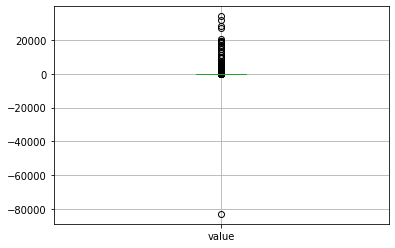

In [48]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [365]:
df[(df['variable'] == 'appCat.builtin')&(df['value'] < -80000)]

,Unnamed: 0,id,time,variable,value
159972,622771,AS14.07,2014-04-30 14:18:06.200,appCat.builtin,-82798.871


In [366]:
df.shape

(376912, 5)

In [367]:
df.drop(159972, axis=0, inplace=True)
df.shape

(376911, 5)

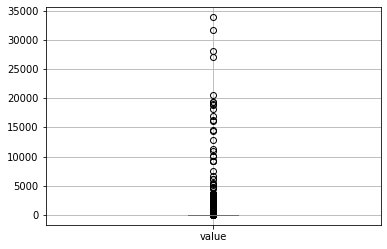

In [52]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [53]:
# df[df['value'] == df[df['variable'] == 'appCat.builtin'].agg({'value': ['min', 'max']})]

#### appCat.entertainment

In [368]:
df[(df['variable'] == 'appCat.entertainment') & (df['value'] < 0)]

,Unnamed: 0,id,time,variable,value
309805,484694,AS14.02,2014-03-26 21:18:45.144,appCat.entertainment,-0.011


In [369]:
df.drop(309805, axis=0, inplace=True)
df.shape

(376910, 5)

#### appCat.office

In [370]:
df[(df['variable'] == 'appCat.office') & (df['value'] > 5000)]

,Unnamed: 0,id,time,variable,value
340707,1356866,AS14.29,2014-04-19 23:15:02.463,appCat.office,32708.818
342284,1360733,AS14.29,2014-05-03 12:34:14.911,appCat.office,5691.982


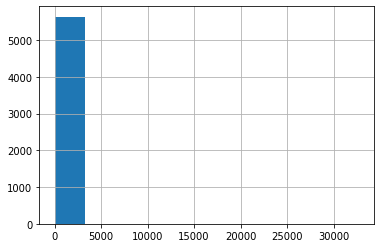

In [371]:
df[df['variable'] == 'appCat.office']['value'].hist();

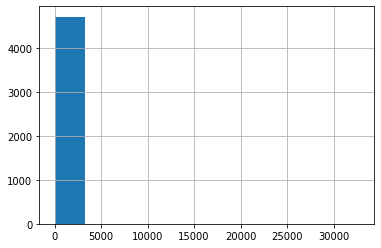

In [372]:
df[(df['id'] == 'AS14.29') & (df['variable'] == 'appCat.office')]['value'].hist();

33k seconds is about 9 hours. In general (and for this subject as well), we see that the time spent in the office apps is significantly smaller so we treat this case as a forgotten opened app

In [373]:
df.drop(340707, axis=0, inplace=True)
df.shape

(376909, 5)

### Activity. Can it be a proxy for sleep? 

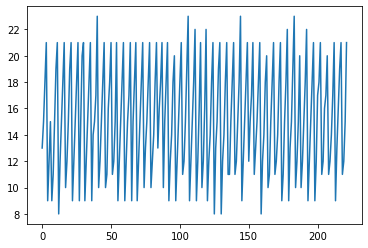

In [60]:
df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.plot();

In [61]:
sorted(df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.unique())

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

<Figure size 1224x864 with 0 Axes>

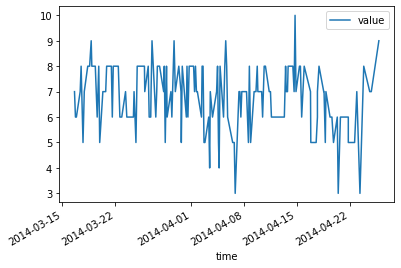

In [62]:
plt.figure(figsize=(17, 12))
df[(df['id'] == 'AS14.02') & (df['variable'] == 'mood')].sort_values(['time']).plot('time', 'value');

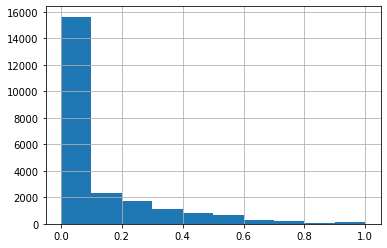

In [63]:
df[df['variable'] == 'activity']['value'].hist();

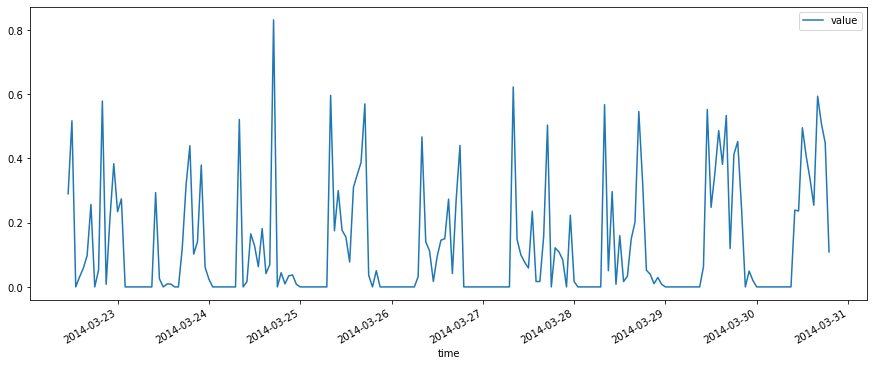

In [571]:
df[(df['id'] == 'AS14.03') & (df['variable'] == 'activity')].sort_values(['time']).head(200).plot(x='time', y='value', figsize=(15,6));

TODO: 
1. add a binary (sth else) feature for sleep\not. sleep should be mutually exclusive with mood records
    1. continous period of 5+ hours
    2. correct it with surrounding events 
2. for each of the users use 75% percentile as sports

### Was the circumplex collected at the same time as the mood?

In [65]:
Image(url= "images/circumplex_model.png", width=400, height=400)

In [66]:
targets_num_df = df[df['variable'].isin(['mood', 'circumplex.valence', 'circumplex.arousal'])].\
    groupby(['id', 'time'])['variable'].unique()
targets_num_df.head()

id       time               
AS14.01  2014-02-26 13:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 15:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 18:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 21:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-27 09:00:00    [mood, circumplex.arousal, circumplex.valence]
Name: variable, dtype: object

In [67]:
targets_num_df[targets_num_df.apply(lambda x: len(x)) != 3]

Series([], Name: variable, dtype: object)

We don't see the cases when mood, circumplex.arousal, circumplex.valence were collected not at the same time. As they are all logically connected, we may conclude that not only the mood was collected as a target during the experiment, but the circumplex as well. Therefore, we have to treat this carefully as including of circumplex while predicting mood for the same time will have a clear leak

### Do we have the same variable indicated at the same time for the same user?

In [68]:
df.duplicated(['id', 'time', 'variable']).value_counts()

False    376866
True         43
dtype: int64

In [69]:
df[df.duplicated(['id', 'time', 'variable'], keep=False)]

,Unnamed: 0,id,time,variable,value
135,136,AS14.01,2014-04-17 11:00:00,mood,7.0
136,137,AS14.01,2014-04-17 11:00:00,mood,6.0
358,359,AS14.02,2014-04-17 18:00:00,mood,6.0
359,360,AS14.02,2014-04-17 18:00:00,mood,7.0
371,372,AS14.02,2014-04-21 20:00:00,mood,5.0
372,373,AS14.02,2014-04-21 20:00:00,mood,6.0
937,938,AS14.06,2014-04-13 17:00:00,mood,7.0
938,939,AS14.06,2014-04-13 17:00:00,mood,5.0
1748,1749,AS14.12,2014-03-30 11:00:00,mood,6.0
1749,1750,AS14.12,2014-03-30 11:00:00,mood,7.0


In [70]:
df[df['variable'] == 'mood']['value'].unique()

array([ 6.,  7.,  5.,  8.,  9.,  4.,  3., 10.,  2.,  1.])

we see the duplicates. probably, they mean fractions (6.5, 0.5 etc)  
TODO Ned: find evidence

In [71]:
df = df.groupby(['id', 'time', 'variable']).mean().reset_index()
df.shape

(376866, 5)

In [163]:
df[(df['id'] == 'AS14.01') & (df['time'] == '2014-04-17 11:00:00')]

,Unnamed: 0,id,time,variable,value
135,136,AS14.01,2014-04-17 11:00:00,mood,7.00000
136,137,AS14.01,2014-04-17 11:00:00,mood,6.00000
5776,5777,AS14.01,2014-04-17 11:00:00,circumplex.arousal,-1.00000
5777,5778,AS14.01,2014-04-17 11:00:00,circumplex.arousal,-2.00000
11419,11420,AS14.01,2014-04-17 11:00:00,circumplex.valence,1.00000
11420,11421,AS14.01,2014-04-17 11:00:00,circumplex.valence,0.00000
17558,17559,AS14.01,2014-04-17 11:00:00,activity,0.05042


the unnamed (index) is weird

## Feature engineering non-dependent on train-test split

time may be encoded with a trigonometrical function to link 23 and 0

check the timing(hour) distribution across the days

don't forget to try find their local times (the first measurement is done in the morning)

## Pivoting data from the previous days as features

## Aggregating and Pivoting

In [362]:
# pivot and fill missing timestamps
df['time'] = df['time'].dt.floor('H')
pivoted_df = pd.pivot_table(df, values = 'value', index=['id','time'], columns = 'variable').reset_index()
for idx in pivoted_df['id'].unique():
    df_missing_data = pd.DataFrame()
    start, end = pivoted_df[pivoted_df['id'] == idx]['time'].agg(['min', 'max'])
    df_missing_data['time'] = pd.date_range(start, end, freq="60min").difference(pivoted_df[pivoted_df['id'] == idx]['time'])
    df_missing_data['id'] = idx

pivoted_df = pd.concat([pivoted_df,df_missing_data]).sort_values(['id', 'time'])
pivoted_df.sort_values(['id', 'time'], inplace=True)

In [363]:
# add binary column for sleep (no activity)
pivoted_df.loc[pivoted_df['activity'] == 0,'asleep'] = 1
pivoted_df['asleep'].fillna(0, inplace=True)

In [364]:
# add binary column for high activity
pivoted_df.loc[pivoted_df['activity'] > 0.5,'active'] = 1
pivoted_df['active'].fillna(0, inplace=True)

In [365]:
# add binary column for missing entry (activity value should be present for every hour)
pivoted_df.loc[pivoted_df['activity'].isna(),'missing_hour'] = 1
pivoted_df['missing_hour'].fillna(0, inplace=True)

In [366]:
# aggregate per mood entry
'''
pivoted_df['id_next'] = pivoted_df['id'].shift(-1)
cols = ['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'screen', 'sms']

empty_row = pivoted_df.iloc[0][cols].fillna(0)*0
current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
for i,row in pivoted_df.fillna(0).iterrows():
    if row['id'] == row['id_next']:
        current_sum += row[cols]
    else:
        current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
        
    if row['mood'] != 0.:
        pivoted_df.loc[i,cols] = current_sum[cols]
        current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
        
pivoted_df.drop(pivoted_df[pivoted_df['mood'].isna() == True].index, inplace=True)
pivoted_df.drop('id_next', axis=1,inplace=True)
''';

In [371]:
# calculate the mood change for the previous day
pivoted_df['time'] = pivoted_df['time'].dt.floor('D')
fist = pd.DataFrame(pivoted_df.loc[~pivoted_df['mood'].isna()].groupby(['id', 'time'])['mood'].first())
last = pd.DataFrame(pivoted_df.loc[~pivoted_df['mood'].isna()].groupby(['id', 'time'])['mood'].last())
mood_change_prev_day = (fist - last).shift(1)
mood_change_prev_day.rename(columns={'mood': 'mood_change_prev'}, inplace=True)

In [372]:
#aggregate daily (different agg func for different columns)
pivoted_df['time'] = pivoted_df['time'].dt.floor('D')
df2 = pivoted_df.groupby(['id', 'time']).mean()[['mood', 'circumplex.arousal', 'circumplex.valence']] #calculate mean for mood and circumplex
df3 = pivoted_df.loc[:, ~pivoted_df.columns.isin(['mood', 'circumplex.arousal', 'circumplex.valence'])].groupby(['id', 'time']).sum() #calculate sum for everything else
pivoted_df = pd.concat([df2,df3, mood_change_prev_day], axis=1).reset_index()

In [373]:
# drop days without mood value
pivoted_df.drop(pivoted_df[pivoted_df['mood'].isna()].index, inplace=True)

In [374]:
# drop days with more than 6 hours missing
pivoted_df.drop(pivoted_df[pivoted_df['missing_hour'] > 6].index, inplace=True)

In [375]:
# add column for mood from previous day and drop rows with no data for previous day
pivoted_df['mood_prev1'] = pivoted_df['mood'].shift(1)
pivoted_df['id_prev1'] = pivoted_df['id'].shift(1)
pivoted_df = pivoted_df[pivoted_df['id_prev1'] == pivoted_df['id']]
pivoted_df.drop('id_prev1', axis=1, inplace=True)

In [376]:
# add day of the week columns
pivoted_df['day_name'] = pivoted_df['time'].dt.day_name()
pivoted_df['day_num'] = pivoted_df['time'].dt.dayofweek

In [377]:
# Estimating weekly seasonality with partial fourier sum
#https://medium.com/analytics-vidhya/how-does-prophet-work-part-2-c47a6ceac511

fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=pivoted_df['time'],
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
f=dp.in_sample()
pivoted_df = pd.concat([pivoted_df.set_index('time'),f],axis=1).reset_index()
pivoted_df.drop('trend', axis=1, inplace=True)

In [378]:
# ordinal time encoding
#enc = ce.OrdinalEncoder(cols=['time'])
#pivoted_df = enc.fit_transform(pivoted_df)

In [380]:
pivoted_df.head(50)

,time,id,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change_prev,mood_prev1,day_name,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
0,2014-02-27,AS14.01,6.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.0,3.0,-1.0,6.250000,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
1,2014-03-21,AS14.01,6.200000,0.200000,0.200000,3.083152,230.019006,763.079384,349.711300,12.334933,0.000,117.243500,193.873000,1214.028518,314.312750,0.00000,197.625786,0.000,4.0,3566.876103,0.0,7.0,2.0,0.0,-1.0,6.333333,Friday,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2,2014-03-22,AS14.01,6.400000,0.600000,0.500000,3.790084,138.338687,882.779741,46.662000,7.025333,0.000,0.000000,98.143000,205.970250,37.305000,0.00000,117.621000,0.000,2.0,656.267264,1.0,1.0,2.0,0.0,0.0,6.200000,Saturday,5,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
3,2014-03-23,AS14.01,6.800000,0.200000,0.800000,2.141117,145.124771,746.957427,49.187000,10.850750,0.000,0.000000,72.823000,369.885567,0.000000,0.00000,30.086000,30.386,0.0,974.988754,0.0,1.0,0.0,0.0,2.0,6.400000,Sunday,6,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
4,2014-03-24,AS14.01,6.000000,0.800000,0.000000,1.895065,84.611298,698.855193,144.745286,11.368667,0.000,3.010000,66.558000,622.299232,83.961000,0.00000,178.732000,0.000,4.0,1313.119081,0.0,10.0,0.0,0.0,1.0,6.800000,Monday,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
5,2014-03-25,AS14.01,6.750000,0.500000,0.500000,2.360979,172.880177,931.204409,68.206000,10.763500,0.000,0.000000,125.156500,700.452361,0.000000,108.26125,44.578600,0.000,0.0,4218.026801,1.0,7.0,1.0,0.0,-1.0,6.000000,Tuesday,1,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
6,2014-03-26,AS14.01,6.600000,-0.200000,0.600000,2.431400,146.039865,893.799534,588.263667,17.443667,0.000,0.000000,97.498000,1504.717317,0.000000,0.00000,33.365000,0.000,0.0,2389.568615,0.0,8.0,1.0,0.0,0.0,6.750000,Wednesday,2,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
7,2014-03-27,AS14.01,7.000000,0.200000,0.800000,3.509234,114.537705,1403.517290,268.855500,14.073000,0.000,28.429444,58.532000,693.608000,23.657000,0.00000,50.243500,0.000,1.0,1468.813362,1.0,9.0,3.0,0.0,0.0,6.600000,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
8,2014-03-28,AS14.01,6.400000,-0.600000,0.600000,2.296753,668.463475,351.740333,527.072167,25.276667,116.518,0.000000,225.951000,314.618821,278.752000,0.00000,84.892917,0.000,2.0,826.462362,0.0,10.0,1.0,0.0,0.0,7.000000,Friday,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
9,2014-03-29,AS14.01,8.000000,0.200000,1.000000,1.636867,302.869607,628.493960,961.423000,0.000000,0.000,0.000000,121.821000,88.853667,17.478333,0.00000,210.479217,0.000,1.0,2468.926018,1.0,8.0,0.0,0.0,-2.0,6.400000,Saturday,5,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490


## Plots + Questions

In [389]:
pd.concat([pivoted_df['mood'] - pivoted_df['mood_prev1'], pivoted_df['mood_change_prev']], axis=1).rename(columns={0: 'mood_change'}).corr()

,mood_change,mood_change_prev
mood_change,1.000000,-0.092077
mood_change_prev,-0.092077,1.000000


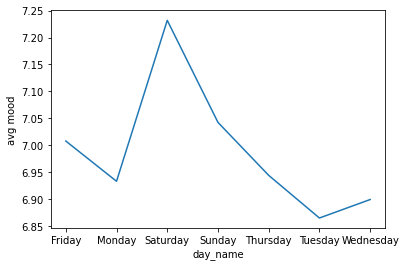

In [206]:
# strong weekly seasonality of mood
pivoted_df.groupby('day_name').mean()['mood'].plot(ylabel='avg mood');

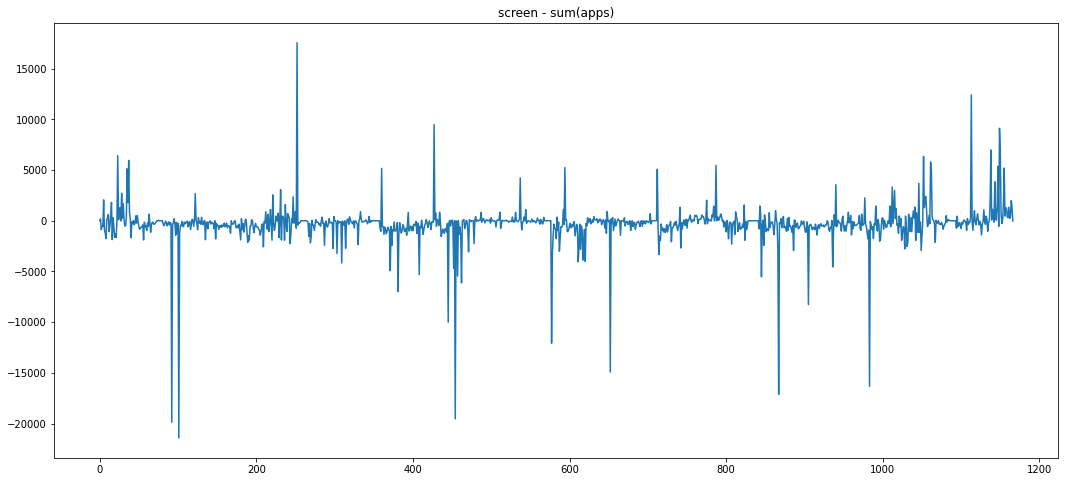

In [207]:
# screen time of apps does not ad up to screen column
%matplotlib inline
apps =  ['appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']
pivoted_df['screen_sum'] = pivoted_df[apps].sum(axis=1)
pivoted_df[['screen','screen_sum']]
(pivoted_df['screen'] - pivoted_df['screen_sum']).plot(figsize=(18,8 ), title='screen - sum(apps)');

### Value for activity missing in more than 14% of the rows!!!
there should be an entry for every hour\
Phone turned off when no data???
currently day deleted if no data for more than 6 hours

## Train-test split

In [240]:
from sklearn.model_selection import train_test_split#, StratifiedKFold

as we are going to predict in the feature, we will be able to train ML models only in the past

In [241]:
pivoted_df = pivoted_df.sort_values(['time'], ascending=True)
pivoted_df.head()

,time,id,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_prev1,day_name,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
0,2014-02-27,AS14.01,6.333333,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.250000,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
568,2014-03-05,AS14.17,8.000000,0.666667,1.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,7.000000,Wednesday,2,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
258,2014-03-06,AS14.08,7.200000,-0.600000,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,6.0,6.333333,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
569,2014-03-06,AS14.17,7.250000,0.500000,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,8.000000,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
259,2014-03-07,AS14.08,7.400000,0.600000,1.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,7.200000,Friday,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521


TODO: consider one model per each id (with a separate split for each)

In [242]:
#pivoted_df['mood'].value_counts()

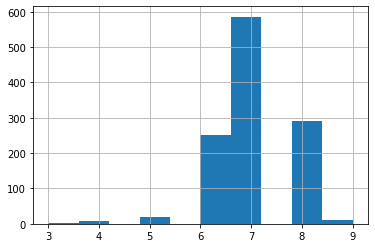

In [243]:
pivoted_df['mood'] = round(pivoted_df['mood'])
pivoted_df['mood'].hist();

In [483]:
y = pivoted_df['mood']

X_train, X_test, y_train, y_test = train_test_split(pivoted_df.drop(['mood', 'time', 'circumplex.arousal', 'circumplex.valence', 'day_name'], axis=1), 
                                                    y, train_size=0.7, shuffle=False)

## Feature engineering

### Categoricals

ID may be encoded in advance as we do not expect new users during test period

In [484]:
enc = ce.OneHotEncoder(cols=['id'], 
                       use_cat_names=True)

X_train = enc.fit_transform(X_train)
print('X_train.shape', X_train.shape)
X_train.head(3)

X_train.shape (816, 47)


,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change_prev,mood_prev1,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.0000,0.000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,3.0,-1.0,6.250000,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.083152,230.019006,763.079384,349.7113,12.334933,0.0,117.2435,193.873,1214.028518,314.31275,0.0,197.625786,0.0,4.0,3566.876103,0.0,7.0,2.0,0.0,-1.0,6.333333,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.790084,138.338687,882.779741,46.6620,7.025333,0.0,0.0000,98.143,205.970250,37.30500,0.0,117.621000,0.0,2.0,656.267264,1.0,1.0,2.0,0.0,0.0,6.200000,5,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490


In [485]:
X_test = enc.transform(X_test)
X_test.tail(2)

,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change_prev,mood_prev1,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
1165,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.064507,91.483901,363.487,136.738000,0.0,0.0,0.0,29.202,548.20500,0.939000,0.000,3.199000,0.0,4.0,2494.684556,1.0,13.0,1.0,0.0,3.0,8.2,3,0.433884,-0.900969,-0.781831,0.62349,0.974928,-0.222521
1166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.050925,202.897677,565.491,169.543333,0.0,0.0,0.0,52.610,592.05377,294.840214,5.559,36.058636,0.0,3.0,1887.579810,0.0,7.0,3.0,3.0,0.0,7.0,4,-0.433884,-0.900969,0.781831,0.62349,-0.974928,-0.222521


### Normalising

# Task 2

## Evaluation

In [486]:
def eval_clf(y_test, test_pred):
    clf_report = classification_report(y_test,
                                       test_pred,)

    print(clf_report)

    conf_matrix = confusion_matrix(y_test,
                                   test_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_test))
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.grid(False)
    disp.plot(ax=ax)

## Predict mood same as previous mood entry baseline (Benchmark Model (4 points))

In [309]:
pivoted_df_per_mood['time'] = df['time'].dt.floor('D')
mood = pivoted_df_per_mood.groupby(['id', 'time']).mean().reset_index()['mood'].round(0)
mood_prev = pivoted_df_per_mood.groupby(['id', 'time']).mean().reset_index()['mood_prev1'].round(0)

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         4
         3.0       0.00      0.00      0.00         0
         4.0       0.12      0.08      0.10        12
         5.0       0.19      0.15      0.17        33
         6.0       0.53      0.52      0.52       298
         7.0       0.70      0.72      0.71       722
         8.0       0.66      0.63      0.65       352
         9.0       0.08      0.08      0.08        12
        10.0       0.00      0.00      0.00         1

    accuracy                           0.63      1434
   macro avg       0.25      0.24      0.25      1434
weighted avg       0.63      0.63      0.63      1434



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (8).

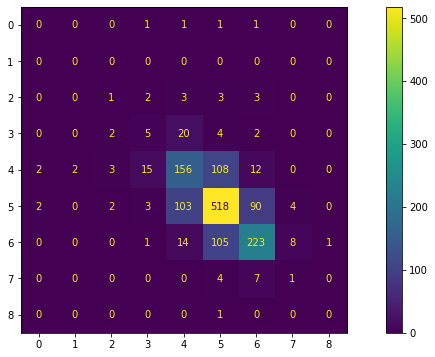

In [310]:
eval_clf(mood, mood_prev)

## Predict mood same as previous day baseline (Benchmark Model (4 points))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.25      0.25      0.25         8
         5.0       0.08      0.09      0.09        23
         6.0       0.45      0.45      0.45       262
         7.0       0.60      0.60      0.60       627
         8.0       0.46      0.46      0.46       308
         9.0       0.00      0.00      0.00        11

    accuracy                           0.52      1241
   macro avg       0.26      0.26      0.26      1241
weighted avg       0.52      0.52      0.52      1241



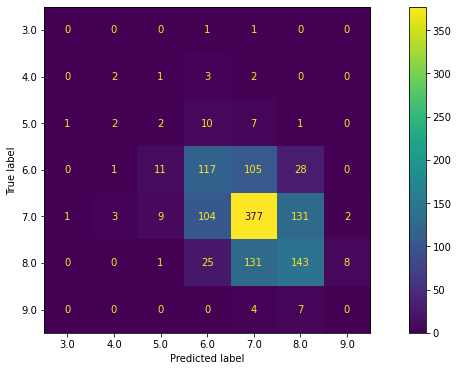

In [299]:
eval_clf(pivoted_df_daily['mood'].round(0), pivoted_df_daily['mood_prev1'].round(0))

## Average baseline (Benchmark Model (4 points))

In [135]:
avg_mood = np.mean(y_train)

In [136]:
avg_mood

7.012401352874859

In [137]:
test_pred = np.full(y_test.shape, round(avg_mood))

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00        12
         6.0       0.00      0.00      0.00        79
         7.0       0.55      1.00      0.71       208
         8.0       0.00      0.00      0.00        80
         9.0       0.00      0.00      0.00         2

    accuracy                           0.55       381
   macro avg       0.11      0.20      0.14       381
weighted avg       0.30      0.55      0.39       381



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

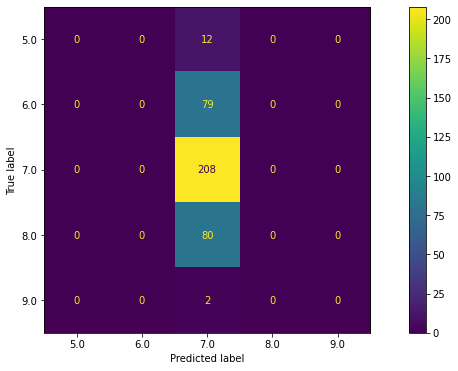

In [138]:
eval_clf(y_test, test_pred)

## Feature Engineered model (8 points)

### DecisionTreeClassifier

In [492]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train.round(0))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       1.00      0.29      0.44         7
         5.0       0.88      0.50      0.64        14
         6.0       0.74      0.20      0.32       194
         7.0       0.61      0.97      0.75       438
         8.0       0.74      0.25      0.37       156
         9.0       0.00      0.00      0.00         5

    accuracy                           0.63       816
   macro avg       0.56      0.32      0.36       816
weighted avg       0.67      0.63      0.56       816



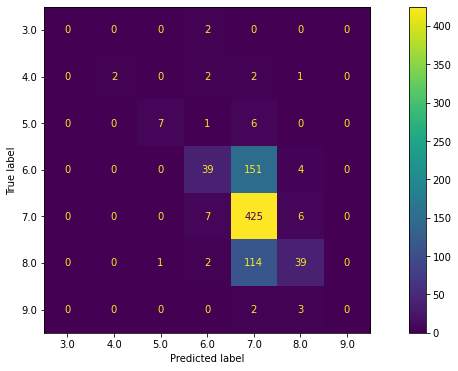

In [496]:
train_pred = clf.predict(X_train)
eval_clf(y_train.round(0), train_pred.round(0))

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         5
         6.0       0.29      0.09      0.14        57
         7.0       0.43      0.95      0.59       148
         8.0       0.67      0.03      0.06       135
         9.0       0.00      0.00      0.00         6

    accuracy                           0.42       351
   macro avg       0.28      0.21      0.16       351
weighted avg       0.49      0.42      0.29       351



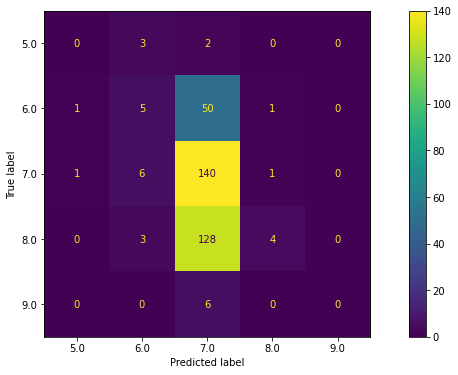

In [497]:
test_pred = clf.predict(X_test)
eval_clf(y_test.round(0), test_pred.round(0))

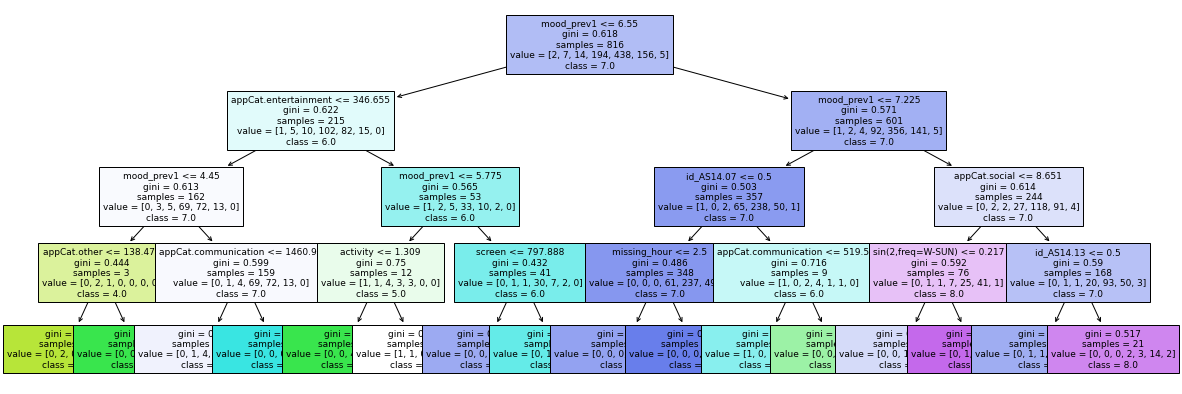

In [498]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1,
                        ncols=1,
                        figsize=(20, 7))

from sklearn import tree
tree.plot_tree(clf, 
               feature_names=X_test.columns, 
               class_names=[str(c) for c in clf.classes_],
            filled=True,
            max_depth=4,
            fontsize=9,
               );

In [499]:
y_test[X_test[X_test['id_AS14.30'] == 1].index]

KeyError: 'id_AS14.30'

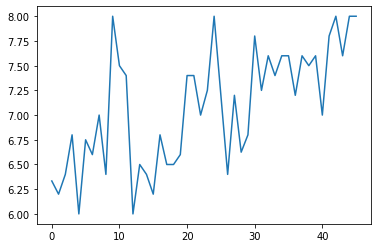

In [500]:
pivoted_df[pivoted_df['id'] == 'AS14.01']['mood'].plot();

### RandomForestClassifier

In [501]:
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       1.00      0.43      0.60         7
         5.0       1.00      0.79      0.88        14
         6.0       0.99      0.68      0.80       194
         7.0       0.77      1.00      0.87       438
         8.0       1.00      0.63      0.77       156
         9.0       1.00      0.20      0.33         5

    accuracy                           0.84       816
   macro avg       0.82      0.53      0.61       816
weighted avg       0.87      0.84      0.83       816



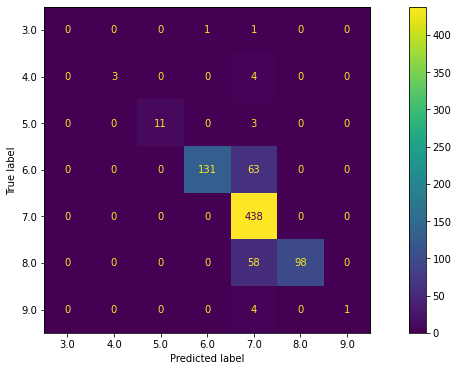

In [519]:
clf = RandomForestClassifier(max_depth=9)
clf = clf.fit(X_train, y_train.round(0))

train_pred = clf.predict(X_train)
eval_clf(y_train.round(0), train_pred.round(0))

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         5
         6.0       0.45      0.16      0.23        57
         7.0       0.43      0.94      0.59       148
         8.0       0.71      0.04      0.07       135
         9.0       0.00      0.00      0.00         6

    accuracy                           0.44       351
   macro avg       0.32      0.23      0.18       351
weighted avg       0.53      0.44      0.31       351



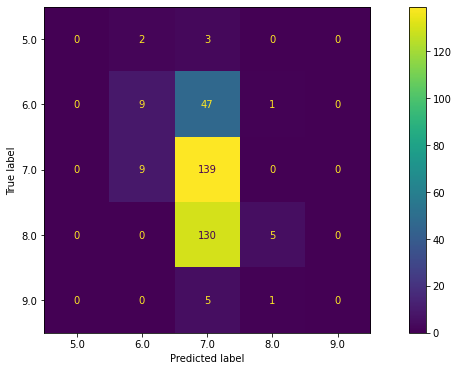

In [520]:
test_pred = clf.predict(X_test)
eval_clf(y_test.round(0), test_pred.round(0))

In [259]:
for el in sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], 
                 reverse=True):
    print(el)

('mood_prev1', 0.12333291212814865)
('appCat.other', 0.05428712425078293)
('screen', 0.05208281924438023)
('id_AS14.30', 0.049027621591504277)
('appCat.communication', 0.04499236439415317)
('activity', 0.0432353277591458)
('appCat.builtin', 0.04127123796863367)
('appCat.entertainment', 0.04058285572581285)
('appCat.social', 0.03888098644429304)
('appCat.travel', 0.0334386903897593)
('asleep', 0.029093368402725497)
('appCat.unknown', 0.025107634049002934)
('appCat.game', 0.023491317390708307)
('sin(1,freq=W-SUN)', 0.022497765309504418)
('appCat.utilities', 0.022201371169713973)
('appCat.finance', 0.02208760753781865)
('call', 0.021567813621181504)
('day_num', 0.02150714765885852)
('id_AS14.03', 0.01865441728888742)
('missing_hour', 0.017510469535584758)
('appCat.office', 0.01696412372896995)
('id_AS14.17', 0.016912967091287208)
('sin(3,freq=W-SUN)', 0.01690183394975801)
('id_AS14.29', 0.01627769766849795)
('sms', 0.016141519367136883)
('sin(2,freq=W-SUN)', 0.016128752502883197)
('active

## Linear Model

In [540]:
scaler = StandardScaler()
scaler.fit_transform(X_train.iloc[:,19:])

array([[-1.14352028, -0.18270866, -0.92175824, ...,  0.87438594,
         1.38952927, -0.32986687],
       [ 0.55308617, -0.03334171,  0.72779261, ...,  0.87438594,
        -1.35475321, -0.32986687],
       [ 0.94209837, -0.09287596,  0.98654921, ..., -1.27132111,
         1.11775987,  0.87269309],
       ...,
       [-0.14061808, -0.0858576 ,  0.57575216, ..., -1.27132111,
        -1.08298381,  0.87269309],
       [-0.01085437,  0.05543322,  1.14530013, ...,  0.87438594,
         1.38952927, -0.32986687],
       [-0.41439526, -0.00884528,  1.4917902 , ...,  0.87438594,
        -1.35475321, -0.32986687]])

In [549]:
model = linear_model.LinearRegression(positive=True)
model.fit(X_train.iloc[:,19:], y_train)

LinearRegression(positive=True)

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         7
         5.0       0.60      0.21      0.32        14
         6.0       0.49      0.24      0.32       194
         7.0       0.57      0.89      0.70       438
         8.0       0.54      0.10      0.16       156
         9.0       0.00      0.00      0.00         5

    accuracy                           0.56       816
   macro avg       0.31      0.21      0.21       816
weighted avg       0.53      0.56      0.49       816



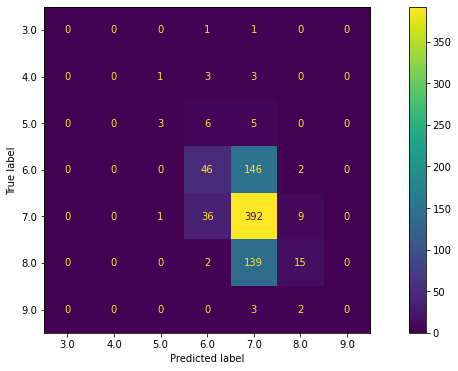

In [550]:
train_pred = pd.DataFrame(model.predict(X_train.iloc[:,19:])).round(0)
eval_clf(y_train.round(0), train_pred.round(0))

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         5
         6.0       0.52      0.21      0.30        57
         7.0       0.46      0.89      0.61       148
         8.0       0.73      0.24      0.36       135
         9.0       0.00      0.00      0.00         6
        11.0       0.00      0.00      0.00         0

    accuracy                           0.50       351
   macro avg       0.29      0.22      0.21       351
weighted avg       0.56      0.50      0.44       351



ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (5).

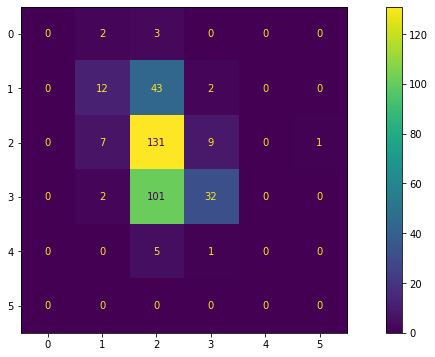

In [551]:
test_pred = pd.DataFrame(model.predict(X_test.iloc[:,19:])).round(0)
eval_clf(y_test.round(0), test_pred.round(0))

## Temporal Model 8

TODO NED: add plots

### AR model

### ARIMA

In [260]:
y = train_test_dict['AS14.01']['train']

# Maps each participant to a fitted model
model_dict = {}
for participant in participants:
    train = train_test_dict[participant]['train']
    
    model = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality (Might have to check for this shit?)
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model_dict[participant] = model

for participant in sorted(model_dict.keys()):
    model = model_dict[participant]
    print(f"{participant}\t\tAIC: {np.round(model.aic(), 2):.2f}\tBIC: {np.round(model.bic(), 2):.2f}\tParameters: {model.order}")

NameError: name 'train_test_dict' is not defined

### Prophet

In [311]:
y_pred = pd.DataFrame()
y_test = pd.DataFrame()
for idx in pivoted_df['id'].unique():
    train = pivoted_df.loc[pivoted_df['id'] == idx,['time', 'mood']].iloc[:-10].rename(columns={'time': 'ds', 'mood': 'y'})
    test = pivoted_df.loc[pivoted_df['id'] == idx,['time', 'mood']].iloc[-10:].rename(columns={'time': 'ds', 'mood': 'y'})

    m = Prophet(interval_width=0.95, weekly_seasonality=True);
    model = m.fit(train);

    #future = m.make_future_dataframe(periods=10,freq='D')
    forecast = m.predict(pd.DataFrame(test['ds']));
    y_pred = pd.concat([y_pred, forecast['yhat']])
    y_test = pd.concat([y_test, test['y']])
    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -2.31957
Iteration  1. Log joint probability =    39.2256. Improved by 41.5452.
Iteration  2. Log joint probability =    61.0849. Improved by 21.8593.
Iteration  3. Log joint probability =    76.8959. Improved by 15.811.
Iteration  4. Log joint probability =    77.4492. Improved by 0.553348.
Iteration  5. Log joint probability =    77.6569. Improved by 0.20765.
Iteration  6. Log joint probability =    77.6652. Improved by 0.00832689.
Iteration  7. Log joint probability =    77.7349. Improved by 0.069657.
Iteration  8. Log joint probability =    77.7637. Improved by 0.0288258.
Iteration  9. Log joint probability =    77.7748. Improved by 0.0111213.
Iteration 10. Log joint probability =     77.788. Improved by 0.0132177.
Iteration 11. Log joint probability =    77.7966. Improved by 0.00852336.
Iteration 12. Log joint probability =     77.804. Improved by 0.00742475.
Iteration 13. Log joint probability =    77.8065. Improved by 0.00248101.
Iteration 14. Lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -9.61709
Iteration  1. Log joint probability =    57.3633. Improved by 66.9804.
Iteration  2. Log joint probability =    71.1178. Improved by 13.7545.
Iteration  3. Log joint probability =    96.7529. Improved by 25.6351.
Iteration  4. Log joint probability =      105.6. Improved by 8.84758.
Iteration  5. Log joint probability =    107.113. Improved by 1.5129.
Iteration  6. Log joint probability =    107.582. Improved by 0.469122.
Iteration  7. Log joint probability =    107.685. Improved by 0.102214.
Iteration  8. Log joint probability =    107.811. Improved by 0.125865.
Iteration  9. Log joint probability =    107.866. Improved by 0.0549734.
Iteration 10. Log joint probability =    107.997. Improved by 0.131738.
Iteration 11. Log joint probability =    108.043. Improved by 0.0460919.
Iteration 12. Log joint probability =    108.055. Improved by 0.0116482.
Iteration 13. Log joint probability =     108.12. Improved by 0.0652666.
Iteration 14. Log joint 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -11.5542
Iteration  1. Log joint probability =    57.3741. Improved by 68.9283.
Iteration  2. Log joint probability =    59.9122. Improved by 2.53813.
Iteration  3. Log joint probability =    62.0442. Improved by 2.13205.
Iteration  4. Log joint probability =    82.7701. Improved by 20.7259.
Iteration  5. Log joint probability =    92.1754. Improved by 9.40529.
Iteration  6. Log joint probability =    92.1874. Improved by 0.012036.
Iteration  7. Log joint probability =    92.1935. Improved by 0.00601062.
Iteration  8. Log joint probability =     92.233. Improved by 0.0395349.
Iteration  9. Log joint probability =    92.2379. Improved by 0.00492405.
Iteration 10. Log joint probability =     92.252. Improved by 0.0140862.
Iteration 11. Log joint probability =    92.4972. Improved by 0.245184.
Iteration 12. Log joint probability =    92.6896. Improved by 0.192401.
Iteration 13. Log joint probability =    93.0478. Improved by 0.358204.
Iteration 14. Log joi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = 0.508334
Iteration  1. Log joint probability =    35.0561. Improved by 34.5478.
Iteration  2. Log joint probability =    41.2219. Improved by 6.16584.
Iteration  3. Log joint probability =    79.1352. Improved by 37.9133.
Iteration  4. Log joint probability =    83.2754. Improved by 4.14023.
Iteration  5. Log joint probability =    83.3361. Improved by 0.0607072.
Iteration  6. Log joint probability =     83.367. Improved by 0.0308486.
Iteration  7. Log joint probability =    83.3985. Improved by 0.0315812.
Iteration  8. Log joint probability =    83.4297. Improved by 0.0311409.
Iteration  9. Log joint probability =    83.4903. Improved by 0.060598.
Iteration 10. Log joint probability =    83.5052. Improved by 0.0149433.
Iteration 11. Log joint probability =    83.5508. Improved by 0.0455688.
Iteration 12. Log joint probability =     83.628. Improved by 0.0772101.
Iteration 13. Log joint probability =    83.6805. Improved by 0.0524772.
Iteration 14. Log 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -2.34272
Iteration  1. Log joint probability =    39.0357. Improved by 41.3785.
Iteration  2. Log joint probability =    60.6448. Improved by 21.6091.
Iteration  3. Log joint probability =    76.4264. Improved by 15.7816.
Iteration  4. Log joint probability =    77.6616. Improved by 1.23521.
Iteration  5. Log joint probability =    77.8739. Improved by 0.212308.
Iteration  6. Log joint probability =    77.8846. Improved by 0.0106668.
Iteration  7. Log joint probability =     77.937. Improved by 0.0524433.
Iteration  8. Log joint probability =    78.1655. Improved by 0.22854.
Iteration  9. Log joint probability =    78.3144. Improved by 0.148844.
Iteration 10. Log joint probability =    78.3439. Improved by 0.0295002.
Iteration 11. Log joint probability =    78.3817. Improved by 0.0377837.
Iteration 12. Log joint probability =    78.3842. Improved by 0.00248655.
Iteration 13. Log joint probability =    78.3877. Improved by 0.0035189.
Iteration 14. Log jo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -5.96369
Iteration  1. Log joint probability =    32.5039. Improved by 38.4676.
Iteration  2. Log joint probability =    46.8749. Improved by 14.371.
Iteration  3. Log joint probability =     48.844. Improved by 1.9691.
Iteration  4. Log joint probability =    49.7544. Improved by 0.910468.
Iteration  5. Log joint probability =    50.2313. Improved by 0.476886.
Iteration  6. Log joint probability =    50.2944. Improved by 0.0630861.
Iteration  7. Log joint probability =    50.3116. Improved by 0.0171831.
Iteration  8. Log joint probability =    50.3421. Improved by 0.0305395.
Iteration  9. Log joint probability =    50.3664. Improved by 0.0242967.
Iteration 10. Log joint probability =    50.3764. Improved by 0.010018.
Iteration 11. Log joint probability =    50.3846. Improved by 0.00816813.
Iteration 12. Log joint probability =    50.3868. Improved by 0.00223551.
Iteration 13. Log joint probability =    50.3907. Improved by 0.00382131.
Iteration 14. Log

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -4.29454
Iteration  1. Log joint probability =    39.9115. Improved by 44.2061.
Iteration  2. Log joint probability =    61.9484. Improved by 22.0368.
Iteration  3. Log joint probability =    69.7059. Improved by 7.75749.
Iteration  4. Log joint probability =    69.8423. Improved by 0.136411.
Iteration  5. Log joint probability =     69.932. Improved by 0.0896839.
Iteration  6. Log joint probability =    69.9417. Improved by 0.0097728.
Iteration  7. Log joint probability =    69.9914. Improved by 0.0496519.
Iteration  8. Log joint probability =    70.0189. Improved by 0.027504.
Iteration  9. Log joint probability =    70.0217. Improved by 0.00276334.
Iteration 10. Log joint probability =    70.0405. Improved by 0.0188724.
Iteration 11. Log joint probability =     70.045. Improved by 0.00444675.
Iteration 12. Log joint probability =    70.0609. Improved by 0.0159376.
Iteration 13. Log joint probability =     70.062. Improved by 0.00112248.
Iteration 14. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -4.31755
Iteration  1. Log joint probability =    24.8922. Improved by 29.2097.
Iteration  2. Log joint probability =     28.838. Improved by 3.94589.
Iteration  3. Log joint probability =    53.9801. Improved by 25.1421.
Iteration  4. Log joint probability =     54.504. Improved by 0.523894.
Iteration  5. Log joint probability =     55.088. Improved by 0.583958.
Iteration  6. Log joint probability =    55.1294. Improved by 0.0413853.
Iteration  7. Log joint probability =    55.1882. Improved by 0.0588015.
Iteration  8. Log joint probability =    55.2479. Improved by 0.0597167.
Iteration  9. Log joint probability =    55.4119. Improved by 0.163952.
Iteration 10. Log joint probability =    55.4908. Improved by 0.0789172.
Iteration 11. Log joint probability =    55.8085. Improved by 0.317707.
Iteration 12. Log joint probability =     55.959. Improved by 0.150543.
Iteration 13. Log joint probability =    56.1596. Improved by 0.200557.
Iteration 14. Log joi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = 0.454561
Iteration  1. Log joint probability =    13.0109. Improved by 12.5564.
Iteration  2. Log joint probability =    63.8433. Improved by 50.8324.
Iteration  3. Log joint probability =    65.2456. Improved by 1.40228.
Iteration  4. Log joint probability =    65.6083. Improved by 0.362667.
Iteration  5. Log joint probability =    65.6107. Improved by 0.00247297.
Iteration  6. Log joint probability =    65.6138. Improved by 0.00302717.
Iteration  7. Log joint probability =    65.6174. Improved by 0.00368198.
Iteration  8. Log joint probability =    65.6276. Improved by 0.0101142.
Iteration  9. Log joint probability =    65.6498. Improved by 0.0222846.
Iteration 10. Log joint probability =    65.7346. Improved by 0.0847575.
Iteration 11. Log joint probability =    65.7771. Improved by 0.0425059.
Iteration 12. Log joint probability =    65.7928. Improved by 0.0156439.
Iteration 13. Log joint probability =    65.8023. Improved by 0.00958179.
Iteration 14

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -1.32678
Iteration  1. Log joint probability =    15.7894. Improved by 17.1162.
Iteration  2. Log joint probability =    75.4489. Improved by 59.6595.
Iteration  3. Log joint probability =    80.2308. Improved by 4.78189.
Iteration  4. Log joint probability =    80.2519. Improved by 0.0211594.
Iteration  5. Log joint probability =    80.2684. Improved by 0.0165174.
Iteration  6. Log joint probability =    80.2906. Improved by 0.0221712.
Iteration  7. Log joint probability =    80.3067. Improved by 0.0161172.
Iteration  8. Log joint probability =    80.3073. Improved by 0.000528941.
Iteration  9. Log joint probability =    80.3156. Improved by 0.00837573.
Iteration 10. Log joint probability =    80.3248. Improved by 0.00914251.
Iteration 11. Log joint probability =    80.3249. Improved by 9.92974e-05.
Iteration 12. Log joint probability =    80.3315. Improved by 0.00660664.
Iteration 13. Log joint probability =    80.3332. Improved by 0.00170659.
Iterati

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -0.334406
Iteration  1. Log joint probability =    67.4731. Improved by 67.8075.
Iteration  2. Log joint probability =    87.6786. Improved by 20.2056.
Iteration  3. Log joint probability =    94.3339. Improved by 6.65526.
Iteration  4. Log joint probability =    97.1851. Improved by 2.85119.
Iteration  5. Log joint probability =    98.2454. Improved by 1.06028.
Iteration  6. Log joint probability =    98.3957. Improved by 0.15032.
Iteration  7. Log joint probability =    98.4385. Improved by 0.0427763.
Iteration  8. Log joint probability =    98.6283. Improved by 0.189877.
Iteration  9. Log joint probability =    98.6587. Improved by 0.030391.
Iteration 10. Log joint probability =     98.766. Improved by 0.107229.
Iteration 11. Log joint probability =    98.7739. Improved by 0.00790055.
Iteration 12. Log joint probability =    98.9569. Improved by 0.183051.
Iteration 13. Log joint probability =    98.9982. Improved by 0.0412902.
Iteration 14. Log joint

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -1.30334
Iteration  1. Log joint probability =    33.1264. Improved by 34.4297.
Iteration  2. Log joint probability =     80.244. Improved by 47.1176.
Iteration  3. Log joint probability =    84.0518. Improved by 3.8078.
Iteration  4. Log joint probability =    84.1478. Improved by 0.096059.
Iteration  5. Log joint probability =    84.1753. Improved by 0.0274391.
Iteration  6. Log joint probability =     84.207. Improved by 0.0317545.
Iteration  7. Log joint probability =    84.2222. Improved by 0.0152074.
Iteration  8. Log joint probability =    84.2303. Improved by 0.00812853.
Iteration  9. Log joint probability =    84.2327. Improved by 0.00235508.
Iteration 10. Log joint probability =    84.2358. Improved by 0.00308361.
Iteration 11. Log joint probability =    84.2368. Improved by 0.00103203.
Iteration 12. Log joint probability =    84.2484. Improved by 0.0115651.
Iteration 13. Log joint probability =    84.2504. Improved by 0.00202787.
Iteration 14

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -1.30596
Iteration  1. Log joint probability =    39.2915. Improved by 40.5974.
Iteration  2. Log joint probability =    62.9318. Improved by 23.6404.
Iteration  3. Log joint probability =    85.7106. Improved by 22.7788.
Iteration  4. Log joint probability =    93.9654. Improved by 8.2548.
Iteration  5. Log joint probability =    93.9688. Improved by 0.00341043.
Iteration  6. Log joint probability =    93.9834. Improved by 0.0145852.
Iteration  7. Log joint probability =    93.9874. Improved by 0.00401487.
Iteration  8. Log joint probability =    93.9898. Improved by 0.00241521.
Iteration  9. Log joint probability =     93.999. Improved by 0.00920517.
Iteration 10. Log joint probability =    94.0036. Improved by 0.00452611.
Iteration 11. Log joint probability =    94.0062. Improved by 0.0026114.
Iteration 12. Log joint probability =    94.0066. Improved by 0.000414431.
Iteration 13. Log joint probability =    94.0068. Improved by 0.000251395.
Iteration

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -0.470344
Iteration  1. Log joint probability =    35.7715. Improved by 36.2418.
Iteration  2. Log joint probability =    57.5358. Improved by 21.7643.
Iteration  3. Log joint probability =    72.2743. Improved by 14.7385.
Iteration  4. Log joint probability =    73.3206. Improved by 1.04634.
Iteration  5. Log joint probability =    73.6605. Improved by 0.339916.
Iteration  6. Log joint probability =    73.6689. Improved by 0.00832878.
Iteration  7. Log joint probability =    73.7578. Improved by 0.0888958.
Iteration  8. Log joint probability =    73.7867. Improved by 0.0288927.
Iteration  9. Log joint probability =    73.7924. Improved by 0.00579651.
Iteration 10. Log joint probability =    73.8717. Improved by 0.0792241.
Iteration 11. Log joint probability =    74.0245. Improved by 0.152842.
Iteration 12. Log joint probability =    74.0622. Improved by 0.0377333.
Iteration 13. Log joint probability =    74.1249. Improved by 0.062613.
Iteration 14. Log

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.



Initial log joint probability = -8.70636
Iteration  1. Log joint probability =    27.8288. Improved by 36.5351.
Iteration  2. Log joint probability =    38.0812. Improved by 10.2525.
Iteration  3. Log joint probability =    51.6903. Improved by 13.609.
Iteration  4. Log joint probability =    52.3582. Improved by 0.667939.
Iteration  5. Log joint probability =    52.3698. Improved by 0.0115946.
Iteration  6. Log joint probability =    52.3968. Improved by 0.0269595.
Iteration  7. Log joint probability =    52.4788. Improved by 0.0820215.
Iteration  8. Log joint probability =    52.5506. Improved by 0.0718279.
Iteration  9. Log joint probability =    52.5521. Improved by 0.00150122.
Iteration 10. Log joint probability =    52.5631. Improved by 0.0109581.
Iteration 11. Log joint probability =    52.5825. Improved by 0.0194409.
Iteration 12. Log joint probability =    52.5872. Improved by 0.00472486.
Iteration 13. Log joint probability =    52.5902. Improved by 0.00297648.
Iteration 14. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -16.2929
Iteration  1. Log joint probability =    10.4679. Improved by 26.7608.
Iteration  2. Log joint probability =    30.6773. Improved by 20.2094.
Iteration  3. Log joint probability =    30.7207. Improved by 0.0433673.
Iteration  4. Log joint probability =    30.7567. Improved by 0.0359683.
Iteration  5. Log joint probability =    30.8276. Improved by 0.070956.
Iteration  6. Log joint probability =    30.8817. Improved by 0.0540868.
Iteration  7. Log joint probability =    30.9425. Improved by 0.060757.
Iteration  8. Log joint probability =    30.9996. Improved by 0.0571045.
Iteration  9. Log joint probability =    31.0827. Improved by 0.083144.
Iteration 10. Log joint probability =     31.167. Improved by 0.0843432.
Iteration 11. Log joint probability =    31.3631. Improved by 0.196029.
Iteration 12. Log joint probability =    34.3245. Improved by 2.96141.
Iteration 13. Log joint probability =    34.3649. Improved by 0.0404503.
Iteration 14. Log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


y =    112.537. Improved by 0.101578.
Iteration 57. Log joint probability =    112.594. Improved by 0.0574062.
Iteration 58. Log joint probability =    112.609. Improved by 0.0145265.
Iteration 59. Log joint probability =    112.674. Improved by 0.0651327.
Iteration 60. Log joint probability =    113.535. Improved by 0.861059.
Iteration 61. Log joint probability =    113.727. Improved by 0.191893.
Iteration 62. Log joint probability =     114.26. Improved by 0.533382.
Iteration 63. Log joint probability =    114.352. Improved by 0.0922798.
Iteration 64. Log joint probability =    114.766. Improved by 0.41348.
Iteration 65. Log joint probability =    115.295. Improved by 0.529315.
Iteration 66. Log joint probability =    115.331. Improved by 0.0358153.
Iteration 67. Log joint probability =    115.469. Improved by 0.138352.
Iteration 68. Log joint probability =    115.531. Improved by 0.0613864.
Iteration 69. Log joint probability =    115.542. Improved by 0.0112122.
Iteration 70. Log jo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.3935
Iteration  1. Log joint probability =     15.024. Improved by 16.4175.
Iteration  2. Log joint probability =    52.4669. Improved by 37.4429.
Iteration  3. Log joint probability =    52.5031. Improved by 0.0361498.
Iteration  4. Log joint probability =    52.5376. Improved by 0.0345791.
Iteration  5. Log joint probability =    52.5816. Improved by 0.043921.
Iteration  6. Log joint probability =    52.6286. Improved by 0.0470624.
Iteration  7. Log joint probability =    52.6932. Improved by 0.0645809.
Iteration  8. Log joint probability =    52.8845. Improved by 0.191304.
Iteration  9. Log joint probability =    52.9129. Improved by 0.0283803.
Iteration 10. Log joint probability =    53.0174. Improved by 0.104555.
Iteration 11. Log joint probability =    57.1289. Improved by 4.11143.
Iteration 12. Log joint probability =    57.1966. Improved by 0.0677057.
Iteration 13. Log joint probability =    57.2073. Improved by 0.0107644.
Iteration 14. Log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.78757
Iteration  1. Log joint probability =    24.8461. Improved by 26.6337.
Iteration  2. Log joint probability =    30.8653. Improved by 6.01919.
Iteration  3. Log joint probability =    42.6226. Improved by 11.7573.
Iteration  4. Log joint probability =    46.5055. Improved by 3.88283.
Iteration  5. Log joint probability =    46.7765. Improved by 0.271063.
Iteration  6. Log joint probability =    46.8196. Improved by 0.0430207.
Iteration  7. Log joint probability =    46.8328. Improved by 0.0132478.
Iteration  8. Log joint probability =    46.8527. Improved by 0.0199239.
Iteration  9. Log joint probability =     46.907. Improved by 0.0542258.
Iteration 10. Log joint probability =    46.9181. Improved by 0.0111865.
Iteration 11. Log joint probability =     47.023. Improved by 0.104813.
Iteration 12. Log joint probability =    47.1097. Improved by 0.0867283.
Iteration 13. Log joint probability =    47.1573. Improved by 0.0476083.
Iteration 14. Log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.



Initial log joint probability = -5.50657
Iteration  1. Log joint probability =    17.4575. Improved by 22.9641.
Iteration  2. Log joint probability =    28.9381. Improved by 11.4806.
Iteration  3. Log joint probability =    28.9633. Improved by 0.0251709.
Iteration  4. Log joint probability =    28.9849. Improved by 0.0216229.
Iteration  5. Log joint probability =    29.0249. Improved by 0.0399841.
Iteration  6. Log joint probability =    29.0702. Improved by 0.0452895.
Iteration  7. Log joint probability =    29.0782. Improved by 0.00799819.
Iteration  8. Log joint probability =    29.0783. Improved by 0.00010296.
Iteration  9. Log joint probability =    29.2094. Improved by 0.131083.
Iteration 10. Log joint probability =    29.6296. Improved by 0.420195.
Iteration 11. Log joint probability =     29.728. Improved by 0.0984366.
Iteration 12. Log joint probability =    29.7962. Improved by 0.0682242.
Iteration 13. Log joint probability =    29.9314. Improved by 0.135194.
Iteration 14. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -5.89843
Iteration  1. Log joint probability =    36.7354. Improved by 42.6338.
Iteration  2. Log joint probability =    51.5539. Improved by 14.8185.
Iteration  3. Log joint probability =    63.3597. Improved by 11.8057.
Iteration  4. Log joint probability =    64.2177. Improved by 0.858059.
Iteration  5. Log joint probability =    64.5986. Improved by 0.380894.
Iteration  6. Log joint probability =     64.665. Improved by 0.0664397.
Iteration  7. Log joint probability =    64.7003. Improved by 0.0352839.
Iteration  8. Log joint probability =    64.7059. Improved by 0.00561775.
Iteration  9. Log joint probability =     64.724. Improved by 0.0180272.
Iteration 10. Log joint probability =     64.733. Improved by 0.00900848.
Iteration 11. Log joint probability =     64.737. Improved by 0.00406636.
Iteration 12. Log joint probability =    64.7415. Improved by 0.0044967.
Iteration 13. Log joint probability =    64.7536. Improved by 0.0120997.
Iteration 14. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -0.817864
Iteration  1. Log joint probability =    51.5283. Improved by 52.3462.
Iteration  2. Log joint probability =    70.6599. Improved by 19.1316.
Iteration  3. Log joint probability =    81.7242. Improved by 11.0643.
Iteration  4. Log joint probability =    82.3906. Improved by 0.666405.
Iteration  5. Log joint probability =    82.6488. Improved by 0.258121.
Iteration  6. Log joint probability =     82.807. Improved by 0.158206.
Iteration  7. Log joint probability =    82.8113. Improved by 0.004305.
Iteration  8. Log joint probability =     82.842. Improved by 0.030746.
Iteration  9. Log joint probability =     82.985. Improved by 0.142965.
Iteration 10. Log joint probability =    83.1218. Improved by 0.136857.
Iteration 11. Log joint probability =    83.1869. Improved by 0.065022.
Iteration 12. Log joint probability =     83.225. Improved by 0.0380996.
Iteration 13. Log joint probability =    83.2395. Improved by 0.0145126.
Iteration 14. Log join

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -2.27809
Iteration  1. Log joint probability =    22.4288. Improved by 24.7069.
Iteration  2. Log joint probability =    52.0521. Improved by 29.6233.
Iteration  3. Log joint probability =    52.0852. Improved by 0.0331444.
Iteration  4. Log joint probability =    52.1216. Improved by 0.0364003.
Iteration  5. Log joint probability =    52.1808. Improved by 0.0591538.
Iteration  6. Log joint probability =    52.1857. Improved by 0.00494779.
Iteration  7. Log joint probability =    52.2873. Improved by 0.101609.
Iteration  8. Log joint probability =    52.2918. Improved by 0.00448855.
Iteration  9. Log joint probability =    52.3962. Improved by 0.104403.
Iteration 10. Log joint probability =    52.4043. Improved by 0.00807265.
Iteration 11. Log joint probability =    52.5078. Improved by 0.103526.
Iteration 12. Log joint probability =    52.5239. Improved by 0.0161016.
Iteration 13. Log joint probability =    52.6226. Improved by 0.0986676.
Iteration 14.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


robability =    66.5405. Improved by 0.000347045.
Iteration 43. Log joint probability =    66.5427. Improved by 0.00219064.
Iteration 44. Log joint probability =    66.5429. Improved by 0.000163124.
Iteration 45. Log joint probability =    66.5441. Improved by 0.00123747.
Iteration 46. Log joint probability =    66.5461. Improved by 0.00200257.
Iteration 47. Log joint probability =    66.5484. Improved by 0.00232098.
Iteration 48. Log joint probability =    66.5487. Improved by 0.00024708.
Iteration 49. Log joint probability =    66.5493. Improved by 0.000661391.
Iteration 50. Log joint probability =    66.5502. Improved by 0.000831794.
Iteration 51. Log joint probability =    66.5513. Improved by 0.00113368.
Iteration 52. Log joint probability =    66.5516. Improved by 0.000291906.
Iteration 53. Log joint probability =    66.5519. Improved by 0.000305204.
Iteration 54. Log joint probability =    66.5521. Improved by 0.000202747.
Iteration 55. Log joint probability =    66.5525. Improv

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.



Initial log joint probability = -11.9366
Iteration  1. Log joint probability =    22.2679. Improved by 34.2045.
Iteration  2. Log joint probability =    31.9893. Improved by 9.72145.
Iteration  3. Log joint probability =    40.2428. Improved by 8.2535.
Iteration  4. Log joint probability =    40.2667. Improved by 0.0238142.
Iteration  5. Log joint probability =    40.4366. Improved by 0.169992.
Iteration  6. Log joint probability =    40.4527. Improved by 0.0160135.
Iteration  7. Log joint probability =    40.4593. Improved by 0.0066243.
Iteration  8. Log joint probability =    40.4677. Improved by 0.0084211.
Iteration  9. Log joint probability =    40.4708. Improved by 0.00309802.
Iteration 10. Log joint probability =    40.4736. Improved by 0.00282403.
Iteration 11. Log joint probability =    40.4745. Improved by 0.000901059.
Iteration 12. Log joint probability =    40.4764. Improved by 0.00183304.
Iteration 13. Log joint probability =    40.4771. Improved by 0.000701832.
Iteration 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -9.73992
Iteration  1. Log joint probability =    51.3455. Improved by 61.0854.
Iteration  2. Log joint probability =    77.4698. Improved by 26.1243.
Iteration  3. Log joint probability =    82.6097. Improved by 5.13992.
Iteration  4. Log joint probability =    89.3184. Improved by 6.70869.
Iteration  5. Log joint probability =    90.7035. Improved by 1.38514.
Iteration  6. Log joint probability =    90.9803. Improved by 0.276831.
Iteration  7. Log joint probability =    91.1483. Improved by 0.167956.
Iteration  8. Log joint probability =    91.2415. Improved by 0.0931955.
Iteration  9. Log joint probability =     91.279. Improved by 0.0375133.
Iteration 10. Log joint probability =     91.521. Improved by 0.241986.
Iteration 11. Log joint probability =    91.5256. Improved by 0.0046488.
Iteration 12. Log joint probability =    91.5466. Improved by 0.0209124.
Iteration 13. Log joint probability =    91.6033. Improved by 0.0567294.
Iteration 14. Log join

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -4.17988
Iteration  1. Log joint probability =    16.3217. Improved by 20.5015.
Iteration  2. Log joint probability =    19.2848. Improved by 2.9631.
Iteration  3. Log joint probability =    52.4223. Improved by 33.1376.
Iteration  4. Log joint probability =    53.6032. Improved by 1.18086.
Iteration  5. Log joint probability =    54.0423. Improved by 0.439064.
Iteration  6. Log joint probability =    54.3762. Improved by 0.333935.
Iteration  7. Log joint probability =     54.455. Improved by 0.0787699.
Iteration  8. Log joint probability =    54.4861. Improved by 0.0311062.
Iteration  9. Log joint probability =    54.4916. Improved by 0.00556954.
Iteration 10. Log joint probability =    54.4983. Improved by 0.00668302.
Iteration 11. Log joint probability =     54.513. Improved by 0.0146263.
Iteration 12. Log joint probability =    54.5158. Improved by 0.00284761.
Iteration 13. Log joint probability =    54.5245. Improved by 0.00872241.
Iteration 14. Lo

              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         0
         5.0       0.18      0.29      0.22         7
         6.0       0.30      0.32      0.31        53
         7.0       0.63      0.63      0.63       136
         8.0       0.53      0.47      0.50        70
         9.0       0.00      0.00      0.00         4

    accuracy                           0.51       270
   macro avg       0.27      0.29      0.28       270
weighted avg       0.52      0.51      0.51       270



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (5).

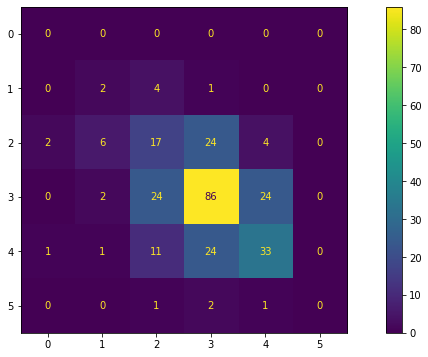

In [312]:
eval_clf(y_test.round(0), y_pred.round(0))

## Evaluation (validation / test) 10

## Illustrate performance with graphs 10